In [ ]:
import yaml
import torch
import json
import argparse
import numpy as np
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from lbfgs import FullBatchLBFGS
from scipy.special import expit, logit
from utils import reparametrized_expanded_params, init_random_params

with open("trained_parameters.yaml", 'r') as file:
    parameters = yaml.safe_load(file)


In [26]:
votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)
deputes = json.load(open('data_parliament/deputes.json', 'r'))
texts = json.load(open('data_parliament/texts.json', 'r'))
n1, n2 = parameters["n1"], parameters["n2"]

In [27]:
nq, nl = parameters["nq"], parameters["nl"]

In [8]:
device = "cuda"

In [29]:
# Define the inverse softplus function with clipping to avoid overflow/underflow
inv_softplus = lambda x: x + np.log(-np.expm1(-np.clip(x, -700, 700)))

# Define the internal shrink simplex transformation with epsilon for stability
shrink_simplex_internal = lambda p: 1 - p[:, :-1] / (np.cumsum(p[:, ::-1], axis=1)[:, :0:-1] + 1e-10)

# Define the shrinkpow function with epsilon to avoid log(0)
shrinkpow = lambda s: np.exp(
    (np.arange(s.shape[1], 0, -1).reshape((1, -1))) * np.log(s + 1e-10)
)

# Combine the functions for the full shrink simplex transformation
shrink_simplex = lambda p: shrinkpow(shrink_simplex_internal(p))

In [32]:
#indices
indices_p = np.argwhere(votes == 1) #argwhere: matrix with couples (row,column) with 1 values 
indices_n = np.argwhere(votes == -1) #idem with -1
indices_zeros = np.argwhere(votes == 0) #idem with 0 

mu_un = parameters["mu_un"][0][0]
sigma_sq_a = parameters["sigma_sq_a"][0][0]
sigma_sq_b = parameters["sigma_sq_b"][0][0]
sigma_sq_p = parameters["sigma_sq_p"][0][0]
sigma_sq_q = parameters["sigma_sq_q"][0][0]
alpha_1 = np.array(parameters['alpha_1']).T
alpha_2 = np.array(parameters['alpha_2'])
pi = np.array(parameters['pi'])
nu_a = np.array(parameters['nu_a']) # (n1, 1)
nu_b = np.array(parameters['nu_b']) # (n1, 1)
nu_p = np.array(parameters['nu_p']) # (1, n2)
nu_q = np.array(parameters['nu_q']) # (1, n2)
rho_a = np.array(parameters['rho_a'])  # (n1, 1)
rho_b = np.array(parameters['rho_b'])  # (n1, 1)
rho_p = np.array(parameters['rho_p'])  # (1, n2)
rho_q = np.array(parameters['rho_q'])  # (1, n2)
tau_1 = np.array(parameters["tau_1"])
tau_2 = np.array(parameters["tau_2"])
theta = np.concatenate(
    (
        (mu_un,),
        (inv_softplus(sigma_sq_a),),
        (inv_softplus(sigma_sq_b),),
        (inv_softplus(sigma_sq_p),),
        (inv_softplus(sigma_sq_q),),
        logit(shrink_simplex(alpha_1).flatten()),
        logit(shrink_simplex(alpha_2).flatten()),
        logit(pi.flatten()),
    )
)
gamma = np.concatenate(
    (
        nu_a.flatten(),
        inv_softplus(rho_a.flatten()),
        nu_b.flatten(),
        inv_softplus(rho_b.flatten()),
        nu_p.flatten(),
        inv_softplus(rho_p.flatten()),
        nu_q.flatten(),
        inv_softplus(rho_q.flatten()),
        logit(shrink_simplex(tau_1).flatten()),
        logit(shrink_simplex(tau_2).flatten()),
    )
)
assert len(theta.shape) == 1
assert theta.shape[0] == 5 + nq - 1 + nl - 1 + nq * nl
assert len(gamma.shape) == 1
assert gamma.shape[0] == 4 * n1 + 4 * n2 + (n1 * (nq - 1)) + (
    n2 * (nl - 1)
)

vector_of_parameters_trained = np.concatenate((gamma, theta))


In [ ]:
import numpy as np

# Fixed inv_softplus
inv_softplus = lambda x: np.where(
    x < -700, 
    x,  # Approximation for large negative inputs
    x + np.log(-np.expm1(-x))
)

logit = lambda x: np.log(x / (1 - x))
shrink_simplex_internal = lambda p: 1 - p[:, :-1] / (np.cumsum(p[:, ::-1], axis=1)[:, :0:-1] + 1e-10)
shrinkpow = lambda s: np.exp(
    (np.arange(s.shape[1], 0, -1).reshape((1, -1))) * np.log(s + 1e-10)
)
shrink_simplex = lambda p: shrinkpow(shrink_simplex_internal(p))

# Extreme value tester
def test_extreme_values(parameters):
    try:
        # Compute values that might cause overflow
        print("Testing inv_softplus...")
        large_negative = -1e6
        print("inv_softplus({}):".format(large_negative), inv_softplus(large_negative))

        print("\nTesting logit...")
        near_zero = 1e-10
        near_one = 1 - 1e-10
        print("logit({}):".format(near_zero), logit(near_zero))
        print("logit({}):".format(near_one), logit(near_one))

        print("\nTesting shrink_simplex...")
        extreme_simplex = np.array([[1e-10, 1e-10, 1 - 2e-10]])  # Simplex edge case
        result = shrink_simplex(extreme_simplex)
        print("shrink_simplex({}):".format(extreme_simplex), result)

    except Exception as e:
        print("An error occurred:", e)

# Example parameter dictionary (replace this with actual parameters)
parameters = {
    "mu_un": [[0]],
    "sigma_sq_a": [[1e-10]],
    "sigma_sq_b": [[1e-10]],
    "sigma_sq_p": [[1e-10]],
    "sigma_sq_q": [[1e-10]],
    "alpha_1": [[0.4, 0.3, 0.3]],
    "alpha_2": [[0.3, 0.5, 0.2]],
    "pi": [[0.5, 0.5]],
    "nu_a": [[0.1]],
    "nu_b": [[0.1]],
    "nu_p": [[0.1]],
    "nu_q": [[0.1]],
    "rho_a": [[1e-10]],
    "rho_b": [[1e-10]],
    "rho_p": [[1e-10]],
    "rho_q": [[1e-10]],
    "tau_1": [[0.5, 0.5]],
    "tau_2": [[0.5, 0.5]],
}

# Run the tester
test_extreme_values(parameters)


Testing inv_softplus...
inv_softplus(-1000000.0): -1000000.0

Testing logit...
logit(1e-10): -23.025850929840455
logit(0.9999999999): 23.025850847100088

Testing shrink_simplex...
shrink_simplex([[1.e-10 1.e-10 1.e+00]]): [[1. 1.]]


C:\Users\Aymane\AppData\Local\Temp\ipykernel_10744\3824214125.py:7: RuntimeWarning: overflow encountered in expm1
  x + np.log(-np.expm1(-x))
C:\Users\Aymane\AppData\Local\Temp\ipykernel_10744\3824214125.py:7: RuntimeWarning: invalid value encountered in log
  x + np.log(-np.expm1(-x))


In [45]:
4 * n1 + 4 * n2 + (n1 * (nq - 1)) + (
    n2 * (nl - 1)
)


13504

In [46]:
theta.shape[0]

26

In [47]:
5 + nq - 1 + nl - 1 + nq * nl

26

In [53]:
import torch
import json
import numpy as np
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from utils import reparametrized_expanded_params, init_random_params

In [33]:
device = 'cuda' #put 'cuda', 'cpu' or 'mps' (for Mac)
device2 = 'cuda'

In [64]:
#votes: matrix gathering votes for several laws and politicians (1: positive, 0: missing/abstention, -1: negative)
votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)

#deputes: Family name, Name, Political group 
deputes = json.load(open('data_parliament/deputes.json', 'r')) 

#texts:  political group demanding the law, title of demand, date, type (type of vote, type of majority, name of type of vote), 
texts = json.load(open('data_parliament/texts.json', 'r')) 

In [65]:
#indices
indices_p = np.argwhere(votes == 1) #argwhere: matrix with couples (row,column) with 1 values 
indices_n = np.argwhere(votes == -1) #idem with -1
indices_zeros = np.argwhere(votes == 0) #idem with 0 

In [66]:
#Shape of votes dataset: number of rows and columns
n1, n2 = votes.shape

# Select number of row clusters
nq = 3# COMPLETE

# Select number of column clusters
nl = 5 # COMPLETE

In [67]:
vector_of_parameters = torch.tensor(init_random_params(n1, n2, nq, nl), requires_grad=True, device=device, dtype=torch.float32)

In [68]:
model = LBM_NMAR(
    vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  3
Number of col classes :  5
 EM step  |   LBFGS iter  | criteria |


c:\Users\Aymane\Desktop\LBM-MNAR-original\LBM-MNAR\lbfgs.py:339: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1642.)
  p.data.add_(


 0  |   1  | 338292.45923 |
 0  |   2  | 324575.25009 |
 0  |   3  | 319333.05076 |
 0  |   4  | 317303.24154 |
 0  |   5  | 316345.20314 |
 0  |   6  | 315904.73723 |
 0  |   7  | 315598.82907 |
 0  |   8  | 315281.98419 |
 0  |   9  | 315033.46645 |
 0  |   10  | 314760.14057 |
 0  |   11  | 314329.46826 |
 0  |   12  | 313873.83443 |
 0  |   13  | 313315.92686 |
 0  |   14  | 312581.12403 |
 0  |   15  | 312001.36836 |
 0  |   16  | 311461.20151 |
 0  |   17  | 310506.28276 |
 0  |   18  | 309757.96681 |
 0  |   19  | 308791.30673 |
 0  |   20  | 307291.58825 |
 0  |   21  | 306201.08705 |
 0  |   22  | 305756.13306 |
 0  |   23  | 305474.65840 |
 0  |   24  | 305412.82018 |
 0  |   25  | 305377.11627 |
 0  |   26  | 305371.48476 |
 0  |   27  | 305371.43936 |
 0  |   28  | 305371.41391 |
 0  |   29  | 305371.40748 |
 0  |   30  | 305371.40374 |
 0  |   31  | 305371.40210 |
 0  |   32  | 305371.40198 |
 0  |   33  | 305371.40193 |
------------------------------  Optimizing next EM s

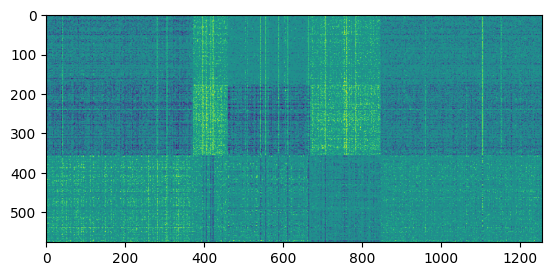

In [3]:
import torch
import json
import argparse
import numpy as np
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from lbfgs import FullBatchLBFGS
from utils import reparametrized_expanded_params, init_random_params



##############" LOADING DATASET" ################

votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)
deputes = json.load(open('data_parliament/deputes.json', 'r'))
texts = json.load(open('data_parliament/texts.json', 'r'))
n1, n2 = votes.shape
nq, nl = 3, 5
device, device2 = "cuda", "cuda"


##############" Init and creating model " ################
vector_of_parameters = torch.tensor(
    init_random_params(n1, n2, nq, nl), requires_grad=True, device=device
)

model = LBM_NMAR(
    vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

try:
    success, loglike = train_with_LBFGS(model)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

# Parameters of the model
(
    nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)

# Get the row and column classes with the MAP on the varitional distributions
tau_1 = np.array(tau_1.tolist())
tau_2 = np.array(tau_2.tolist())
row_classes = tau_1.argmax(axis=1)
column_classes = tau_2.argmax(axis=1)
print("Texts classes : ", column_classes)
print("MPs classes : ", row_classes)
print([[(deputes[i]['nom'], deputes[i]['groupe']) for i, c in enumerate(row_classes) if c == nq] for nq in range(nq)])

######### Display the vote matrix, rows and columns re-ordered according to their respective classes.
import matplotlib.pyplot as plt
plt.imshow(
    votes[np.argsort(tau_1.argmax(axis=1)), :][
        :, np.argsort(tau_2.argmax(axis=1))
    ]
)
plt.show()


In [ ]:
model_with_trained_vect = LBM_NMAR(
    vector_of_parameters_trained,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

In [ ]:
try:
    success, loglike = train_with_LBFGS(model)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

# Parameters of the model
(
    nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)



-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  3
Number of col classes :  5
 EM step  |   LBFGS iter  | criteria |
 0  |   1  | 373822.52184 |
 0  |   2  | 332051.40802 |
 0  |   3  | 324749.97067 |
 0  |   4  | 320228.67316 |
 0  |   5  | 318460.01857 |
 0  |   6  | 317628.00359 |
 0  |   7  | 317267.06713 |
 0  |   8  | 317023.40003 |
 0  |   9  | 316702.59973 |
 0  |   10  | 316477.81489 |
 0  |   11  | 316101.00332 |
 0  |   12  | 315779.63589 |
 0  |   13  | 315136.90725 |
 0  |   14  | 314545.30771 |
 0  |   15  | 313720.75201 |
 0  |   16  | 312889.03210 |
 0  |   17  | 312147.59173 |
 0  |   18  | 311311.96941 |
 0  |   19  | 310326.16570 |
 0  |   20  | 309377.88484 |
 0  |   21  | 308399.84975 |
KeyboardInterrupt detected, stopping training


Texts classes :  [4 0 0 ... 2 3 2]
MPs classes :  [2 0 0 1 0 2 1 1 1 1 2 2 0 2 0 0 1 2 2 0 2 2 0 0 1 2 1 0 0 2 2 2 1 0 1 1 0
 0 0 0 0 1 2 2 1 0 0 0 2 2 1 0 1 1 0 2 1 0 2 0 2 1 0 0 1 1 2 2 0 2 0 2 2 2
 1 1 2 2 0 2 2 1 1 1 1 1 1 2 0 0 1 2 0 1 2 2 0 1 0 1 2 0 1 1 1 2 0 1 1 2 2
 0 0 2 2 2 2 2 1 0 1 2 1 1 0 1 0 2 1 0 2 2 0 2 0 2 2 2 1 2 0 2 0 2 0 1 0 1
 2 2 2 2 0 0 0 1 1 2 2 0 2 0 1 0 1 2 2 0 1 1 1 1 0 1 0 2 2 2 2 0 2 2 2 0 1
 0 1 2 2 0 1 0 1 2 0 0 2 2 0 0 2 2 2 1 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 1 1 0
 0 2 1 0 1 1 1 0 0 1 2 2 0 0 2 2 2 2 0 0 0 0 2 1 2 1 2 0 2 0 2 0 2 0 2 2 2
 1 1 0 0 2 0 1 1 1 0 1 2 2 2 0 1 0 2 2 1 2 2 2 2 2 1 1 1 1 0 2 2 1 0 0 0 1
 1 0 0 1 0 2 1 2 0 0 1 1 0 1 2 1 0 1 0 1 0 0 1 0 2 2 1 2 0 1 2 2 0 1 2 2 2
 1 2 2 2 1 2 1 1 2 2 1 1 1 1 0 2 2 2 0 0 1 2 1 1 2 1 1 0 1 2 0 2 2 1 2 2 2
 1 2 0 2 1 1 1 2 0 1 2 0 1 2 2 2 2 2 0 2 1 0 2 1 1 2 2 1 1 1 2 2 2 2 1 0 1
 0 2 2 0 0 1 2 1 1 0 2 1 0 2 2 0 2 1 2 0 0 1 1 0 2 2 0 0 2 1 2 1 2 0 1 0 2
 2 1 0 2 0 2 0 2 0 1 0 2 0 1 1 0 1 0 0 1 2 0 0 1 0

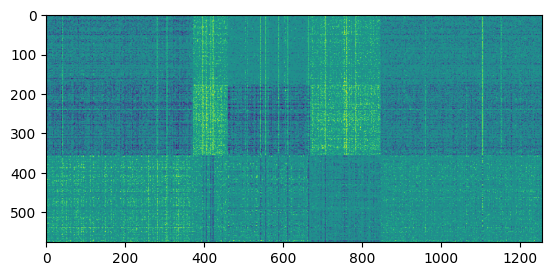

In [46]:
# Get the row and column classes with the MAP on the varitional distributions
tau_1 = np.array(tau_1.tolist())
tau_2 = np.array(tau_2.tolist())
row_classes = tau_1.argmax(axis=1)
column_classes = tau_2.argmax(axis=1)
print("Texts classes : ", column_classes)
print("MPs classes : ", row_classes)
print([[(deputes[i]['nom'], deputes[i]['groupe']) for i, c in enumerate(row_classes) if c == nq] for nq in range(nq)])

######### Display the vote matrix, rows and columns re-ordered according to their respective classes.
import matplotlib.pyplot as plt
plt.imshow(
    votes[np.argsort(tau_1.argmax(axis=1)), :][
        :, np.argsort(tau_2.argmax(axis=1))
    ]
)
plt.show()

In [70]:
from figures import *

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Figure_17.pdf'

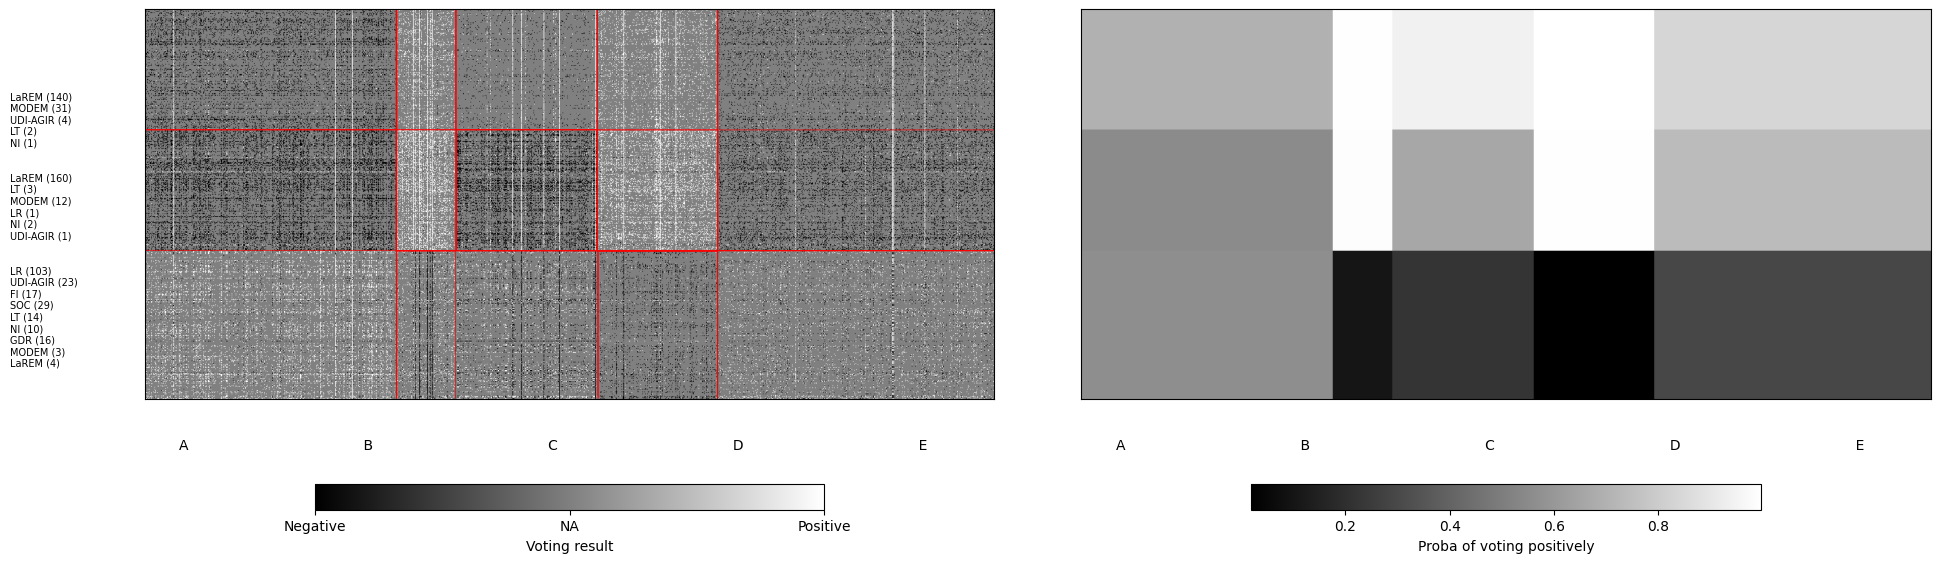

In [71]:
fig_17(votes, deputes, row_classes, column_classes, pi)

In [64]:
intial_random_vector_of_parameters = torch.load("intial_random_vector_of_parameters.pt")

C:\Users\Aymane\AppData\Local\Temp\ipykernel_10744\733879683.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intial_random_vector_of_parameters = torch.load("intial_rand

In [65]:
model_with_random_init_trained_vect = LBM_NMAR(
    intial_random_vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

In [67]:
try:
    success, loglike = train_with_LBFGS(model_with_random_init_trained_vect)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

# Parameters of the model
(
    nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)



-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  3
Number of col classes :  5
 EM step  |   LBFGS iter  | criteria |
 0  |   1  | 373822.52184 |
 0  |   2  | 332051.40802 |
 0  |   3  | 324749.97067 |
 0  |   4  | 320228.67316 |
 0  |   5  | 318460.01857 |
 0  |   6  | 317628.00359 |
 0  |   7  | 317267.06713 |
 0  |   8  | 317023.40003 |
 0  |   9  | 316702.59973 |
 0  |   10  | 316477.81489 |
 0  |   11  | 316101.00332 |
 0  |   12  | 315779.63589 |
 0  |   13  | 315136.90725 |
 0  |   14  | 314545.30771 |
 0  |   15  | 313720.75201 |
 0  |   16  | 312889.03210 |
 0  |   17  | 312147.59173 |
 0  |   18  | 311311.96941 |
 0  |   19  | 310326.16570 |
 0  |   20  | 309377.88484 |
 0  |   21  | 308399.84975 |
 0  |   22  | 307747.93603 |
 0  |   23  | 307560.83536 |
 0  |   24  | 307395.68840 |
 0  |   25  | 307392.29756 |
 0